# Sentiment Analysis for Movie Reviews

We are going to be exploring the Standford Large Movie Review Dataset http://ai.stanford.edu/~amaas/data/sentiment/

In [1]:
import nltk 
# nltk.download()

from sklearn.feature_selection import f_classif

import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

### Read in text data

The data is saved in the following file structure

In [2]:
import os
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', 200) # set max number of characters can see in pd dataframe

#path location to the directory
path = 'data/aclimdb'

# Load the dataset
train_texts = []
train_labels = []
test_texts = []
test_labels = []

for dataset in ['train', 'test']:
    for category in ['pos', 'neg']:
        dataset_path = os.path.join(path, dataset, category)
        for fname in os.listdir(dataset_path):
            if fname.endswith('.txt'):
                with open(os.path.join(dataset_path, fname)) as f:
                    
                    if dataset == 'train': train_texts.append(f.read())
                    else: test_texts.append(f.read())
                
                label = 0 if category == 'neg' else 1
                if dataset == 'train': 
                    train_labels.append(label)
                else: 
                    test_labels.append(label)

# Converting to np.array
train_texts = np.array(train_texts)
train_labels = np.array(train_labels)
test_texts = np.array(test_texts)
test_labels = np.array(test_labels)

print ('Train samples shape :', train_texts.shape)
print ('Train labels shape  :', train_labels.shape)
print ('Test samples shape  :', test_texts.shape)
print ('Test labels shape   :', test_labels.shape)

Train samples shape : (25000,)
Train labels shape  : (25000,)
Test samples shape  : (25000,)
Test labels shape   : (25000,)


In [3]:
uniq_class_arr, counts = np.unique(train_labels, return_counts=True)

print ('Unique classes :', uniq_class_arr)
print ('Number of unique classes : ', len(uniq_class_arr))

for _class in uniq_class_arr:
    print ('Counts for class ', uniq_class_arr[_class], ' : ', counts[_class])


Unique classes : [0 1]
Number of unique classes :  2
Counts for class  0  :  12500
Counts for class  1  :  12500


In [4]:
size_of_samp = 10
rand_samples_to_check = np.random.randint(len(train_texts), size=size_of_samp)

for samp_num in rand_samples_to_check:
    print ('============================================================')
    print (train_texts[samp_num], '||', train_labels[samp_num])
    print ('============================================================')

I'm far from a Sylvester Stallone fan and I guess the only time I really appreciated his appearance was in the French movie Taxi 3, which is an almost inexistent small role. And yet I must admit that this movie was actually not that bad, even though I feared the worst.<br /><br />When Gabe (Stallone) fails to rescue the girlfriend of one of his friends and she plunges to her death from a 4000 feet high mountain top, he can't possibly force himself to keep working as a mountain ranger. For almost a year he doesn't set a food in the reserve, but than he returns. Soon after he's back, they get an emergency call from a group of hikers who got trapped in a snow storm. At least, that's what the rangers believe. In reality it is a group of robbers who crashed with their airplane in the mountains after their daring plan to steal cases full of money from a flying government plane failed. The cases are spread all over the reserve and they need the help of professional climbers to retrieve them..

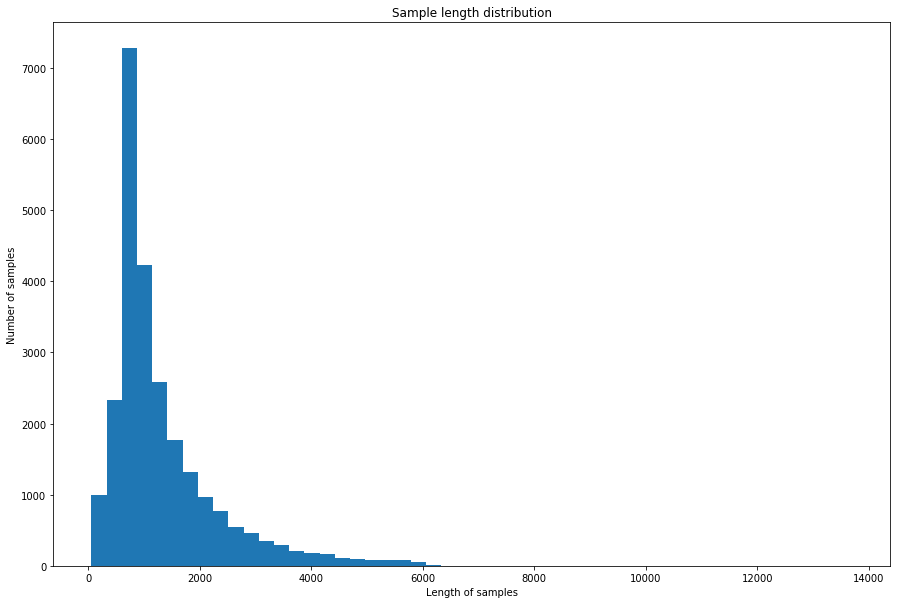

In [5]:
#average number of words per sample
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15, 10))
plt.hist([len(sample) for sample in list(train_texts)], 50)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

In [6]:
#shuffle the positive and negative reviews and reset the index 

full_corpus = pd.DataFrame({
    'label': train_labels,
    'body': train_texts
})

data = full_corpus.sample(frac=1).reset_index(drop=True)
data = data[:15000]
data.head(10)

,label,body
0,1,The story of this film is truly remarkable. A virus cut loose and only 1% of the human race survived. The only thing we know now is that animals rule the land above and there are posters everywher...
1,1,"Sensitive film does lack brilliance and, to some degree, narrative structure, but is nevertheless superbly shot and performed. However, the narrative structure point is debatable. While it gives t..."
2,1,"Wow, this movie was absolutely brilliant. I really don't know why everyone says it has a slow pace. I thought the pace was perfect. The movie is about Michael Sullivan played by Tom Hanks with per..."
3,0,"When you're making a thriller about witchcraft, I believe you should do everything you can to help the audience suspend its disbelief in order for the movie to work. Some pictures (""Rosemary's Bab..."
4,0,"*****WARNING, MAY CONTAIN SPOILERS WHICH WILL BE MORE ENTERTAINING THAN THIS TRIPE.**** <br /><br />Heres some good advise to anyone living in the U.K. Whenever Channel 5 has an old 80's comedy on..."
5,1,"The literary genius of Vladimir Navokov is brought to the screen again and many in the cultured world will take notice. The director puts us in check mate with the story of Alexander, an absentmin..."
6,0,"""National Treasure"" (2004) is a thoroughly misguided hodge-podge of plot entanglements that borrow from nearly every cloak and dagger government conspiracy cliché that has ever been written. The f..."
7,1,"Like most other reviewers I have first seen this movie (on TV, never on the big screen), when I was a teenager. My Dad has always regarded this film highly and recommended it to me then, and I mus..."
8,0,"Not much to say on this one. A plot you can pretty much peg, in the first 10 minutes. Nothing overly wrong with this film, very little action for an action film. There was a chance to explore the ..."
9,1,"My main problem with the film is that it goes on too long. Other then that, it's pretty good. Paul Muni plays a poor Chinese farmer who is about to get married through an arranged marriage. Luise ..."


### Exploring Dataset

In [7]:
# What is the shape of this datataset

print("Input data has {} rows and {} columns".format(len(data), len(data.columns)))

Input data has 15000 rows and 2 columns


In [8]:
# How many revies are negative and positive?

print("Out of {} rows, {} are negative, {} are positive".format(len(data), 
                                                       len(data[data['label']==0]), 
                                                       len(data[data['label']==1])))

Out of 15000 rows, 7510 are negative, 7490 are positive


In [9]:
# Is there any missing data?
print("Number of null in label: {}".format(data['label'].isnull().sum()))
print("Number of null in text: {}".format(data['body'].isnull().sum()))

Number of null in label: 0
Number of null in text: 0


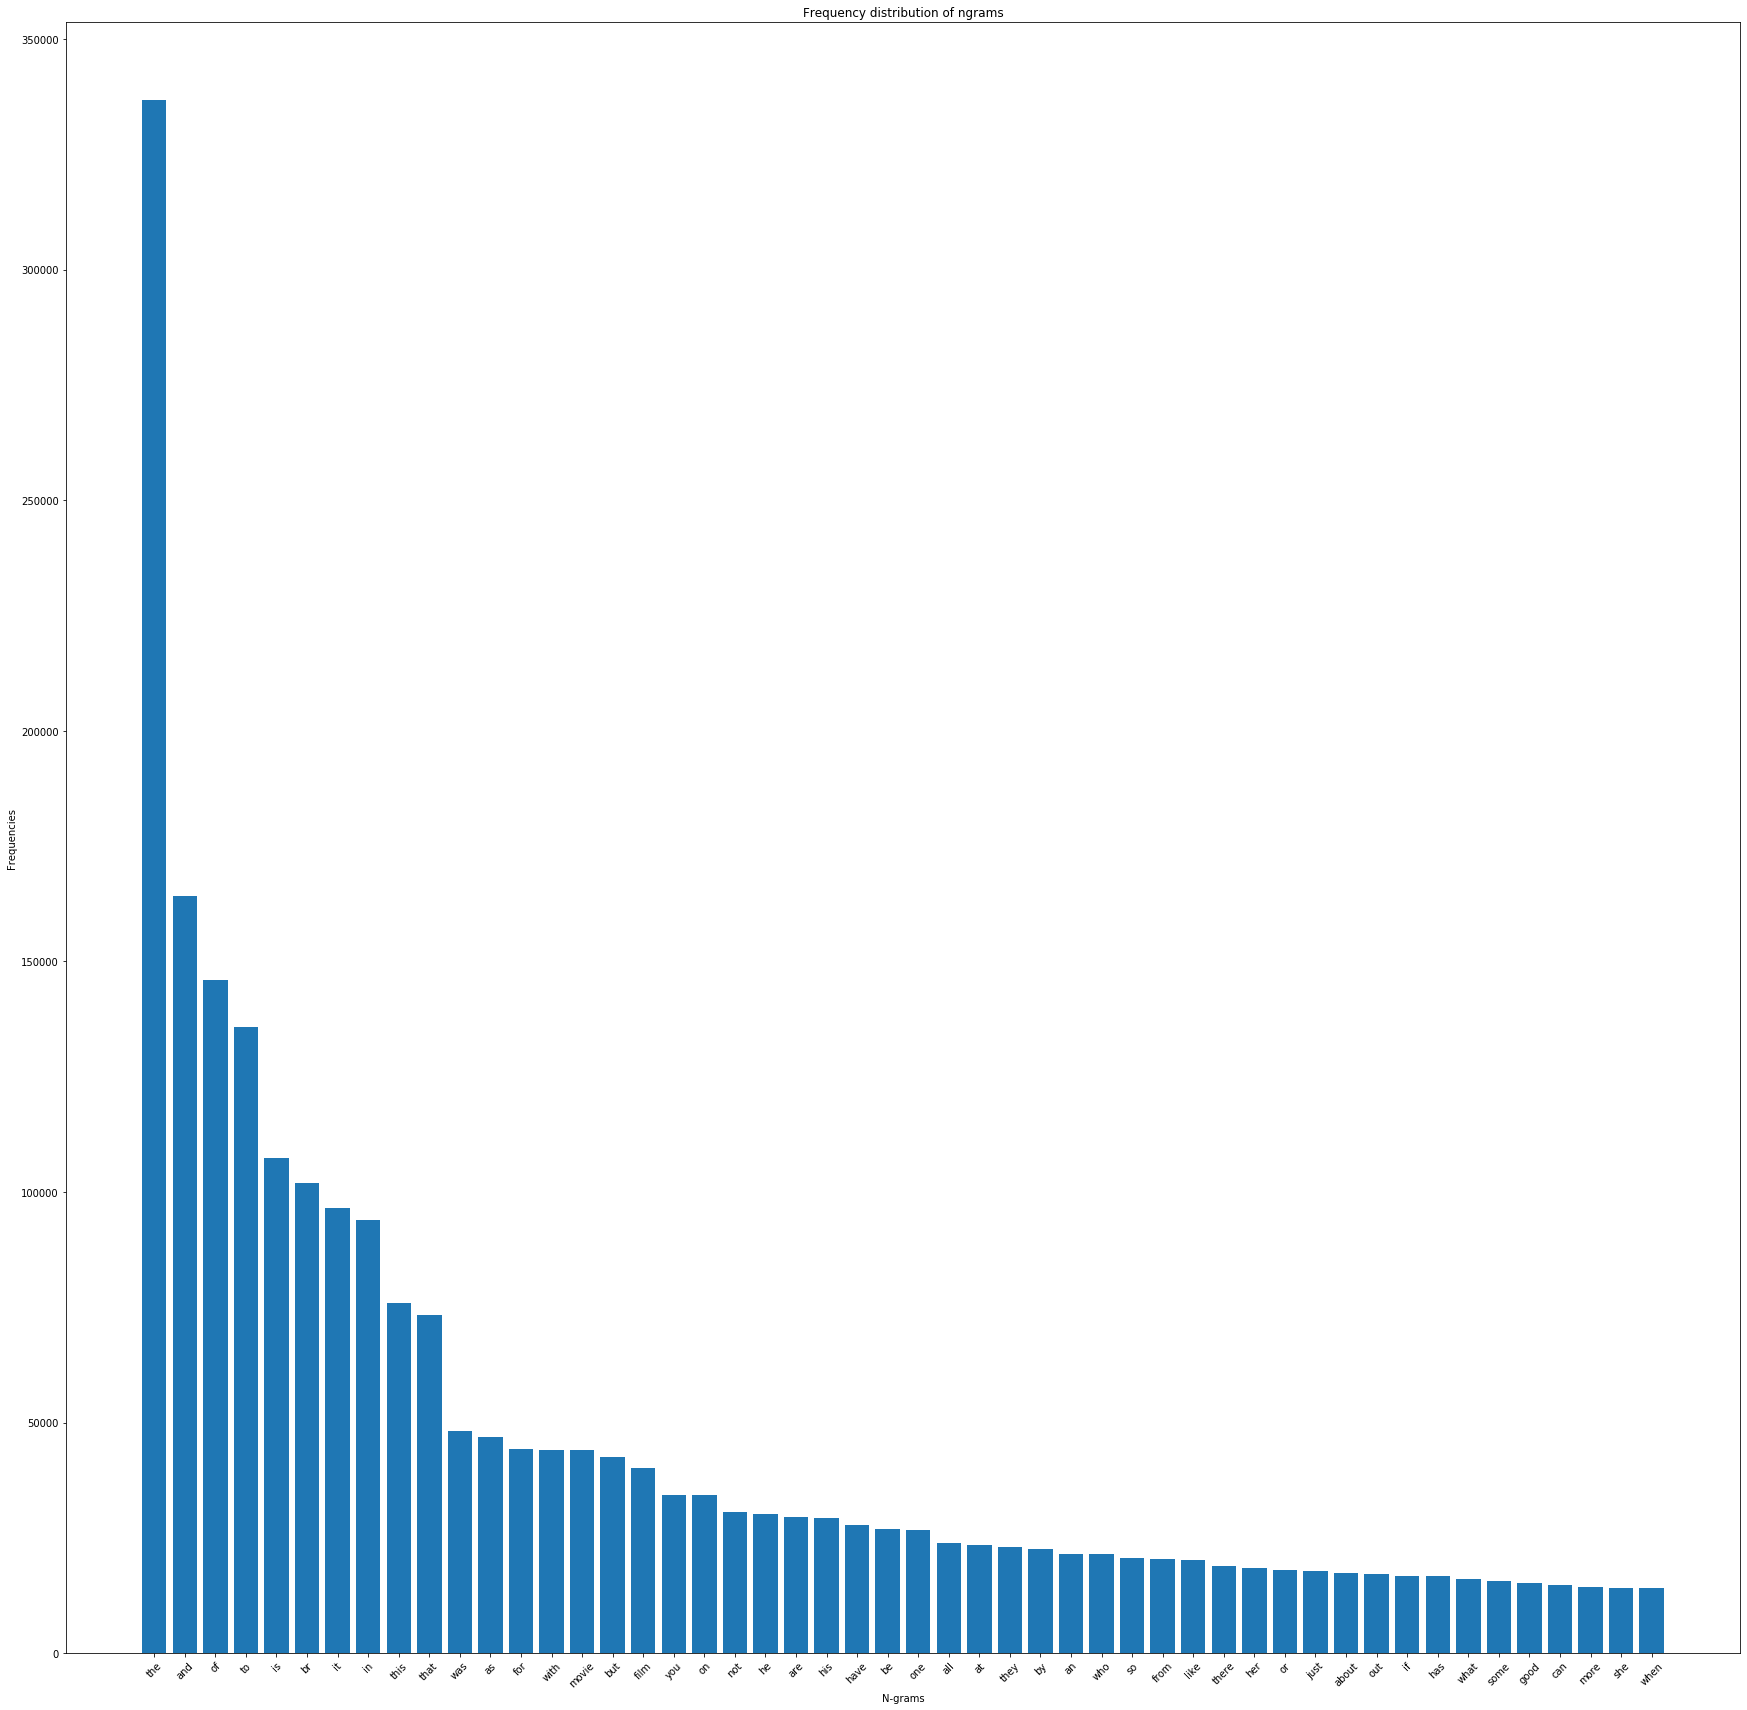

In [10]:
#Let's now plot a frequency distribution plot of the most seen words in the corpus.

from sklearn.feature_extraction.text import CountVectorizer

kwargs = {
    'ngram_range' : (1, 1),
    'dtype' : 'int32',
    'strip_accents' : 'unicode',
    'decode_error' : 'replace',
    'analyzer' : 'word'
}

vectorizer = CountVectorizer(**kwargs)
vect_texts = vectorizer.fit_transform(list(train_texts))
all_ngrams = vectorizer.get_feature_names()
num_ngrams = min(50, len(all_ngrams))
all_counts = vect_texts.sum(axis=0).tolist()[0]

all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

plt.figure(figsize=(30, 30))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest

NGRAM_RANGE = (1, 2)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    kwargs = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : TOKEN_MODE,
        'min_df' : MIN_DOC_FREQ,
    }
    
    # Learn Vocab from train texts and vectorize train and val sets
    tfidf_vectorizer = TfidfVectorizer(**kwargs)
    x_train = tfidf_vectorizer.fit_transform(train_texts)
    x_val = tfidf_vectorizer.transform(val_texts)
    
    # Select best k features, with feature importance measured by f_classif
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val


In [12]:
def get_last_layer_units_and_activation(num_classes):
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [13]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    op_units, op_activation = get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))
    
    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))
        
    model.add(Dense(units=op_units, activation=op_activation))
    return model

In [43]:
def train_ngram_model(data, learning_rate=1e-3, epochs=1000, batch_size=128, layers=2, units=64, 
                      dropout_rate=0.2):
    
    num_classes = 2
    
    # Get the data
    trX, trY, ttX, ttY = data
    
    # Verify the validation labels
    '''
    unexpected_labels = [v for v in ttY if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the labels'
                         ' in the validation set are in the same range as '
                         'training labels.'.format(unexpected_labels=unexpected_labels))
    '''
    
    # Vectorize the data
    x_train, x_val = ngram_vectorize(trX, trY, ttX)
    
    # Create model instance
    model = mlp_model(layers, units=units, dropout_rate=dropout_rate,
                      input_shape=x_train.shape[1:], num_classes=num_classes)
    
    # Compile model with parameters
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
    
    # Create callback for early stopping on validation loss. If the loss does
    # not decrease on two consecutive tries, stop training
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
    
    # Train and validate model
    history = model.fit(x_train, trY, epochs=epochs, validation_data=(x_val, ttY),
                        verbose=2, batch_size=batch_size, callbacks=callbacks)
    
    # Print results
    history = history.history
    val_acc = history['val_acc'][-1]
    val_loss = history['val_loss'][-1]
    print ('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=val_acc, loss=val_loss))
    
    # Save model
    model.save('IMDB_mlp_model_' + str(val_acc) + '_' + str(loss) + '.h5')
    return val_acc, val_loss

In [15]:
results = train_ngram_model((train_texts, train_labels, test_texts, test_labels))

print ('With lr=1e-3 | val_acc={results[0]} | val_loss={results[1]}'.format(results=results))
print ('===========================================================================================')

/Users/alex/Desktop/NLP/sentiment_analysis_movie_review/venv/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1616: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)
W0714 12:19:31.219905 140735564440448 deprecation.py:506] From /Users/alex/Desktop/NLP/sentiment_analysis_movie_review/venv/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0714 12:19:31.270990 140735564440448 deprecation.py:323] From /Users/alex/Desktop/NLP/sentiment_analysis_movie_review/venv/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflo

Train on 25000 samples, validate on 25000 samples
Epoch 1/1000
25000/25000 - 3s - loss: 0.4713 - acc: 0.8598 - val_loss: 0.3223 - val_acc: 0.8874
Epoch 2/1000
25000/25000 - 3s - loss: 0.2312 - acc: 0.9227 - val_loss: 0.2507 - val_acc: 0.9022
Epoch 3/1000
25000/25000 - 3s - loss: 0.1693 - acc: 0.9409 - val_loss: 0.2350 - val_acc: 0.9053
Epoch 4/1000
25000/25000 - 3s - loss: 0.1340 - acc: 0.9545 - val_loss: 0.2315 - val_acc: 0.9053
Epoch 5/1000
25000/25000 - 3s - loss: 0.1106 - acc: 0.9650 - val_loss: 0.2332 - val_acc: 0.9047
Epoch 6/1000
25000/25000 - 3s - loss: 0.0956 - acc: 0.9693 - val_loss: 0.2409 - val_acc: 0.9030
Validation accuracy: 0.9030399918556213, loss: 0.24085475805282594
With lr=1e-3 | val_acc=0.9030399918556213 | val_loss=0.24085475805282594


## Pre-processing text data

Clean up the text data by removing unnecesary information with tools such as :
- Removing punctuation
- Tokenization 
- Removing stopwords
- Lemmatizing/Stemming words

### Removing breaks br

In [16]:
import re 

def remove_breaks(text):
    text_nobreaks = [re.sub("<br />", '', text)]
    return text_nobreaks

data['body_nobreaks'] = data['body'].apply(lambda x: remove_breaks(x))
data.head(5)

,label,body,body_nobreaks
0,1,The story of this film is truly remarkable. A virus cut loose and only 1% of the human race survived. The only thing we know now is that animals rule the land above and there are posters everywher...,[The story of this film is truly remarkable. A virus cut loose and only 1% of the human race survived. The only thing we know now is that animals rule the land above and there are posters everywhe...
1,1,"Sensitive film does lack brilliance and, to some degree, narrative structure, but is nevertheless superbly shot and performed. However, the narrative structure point is debatable. While it gives t...","[Sensitive film does lack brilliance and, to some degree, narrative structure, but is nevertheless superbly shot and performed. However, the narrative structure point is debatable. While it gives ..."
2,1,"Wow, this movie was absolutely brilliant. I really don't know why everyone says it has a slow pace. I thought the pace was perfect. The movie is about Michael Sullivan played by Tom Hanks with per...","[Wow, this movie was absolutely brilliant. I really don't know why everyone says it has a slow pace. I thought the pace was perfect. The movie is about Michael Sullivan played by Tom Hanks with pe..."
3,0,"When you're making a thriller about witchcraft, I believe you should do everything you can to help the audience suspend its disbelief in order for the movie to work. Some pictures (""Rosemary's Bab...","[When you're making a thriller about witchcraft, I believe you should do everything you can to help the audience suspend its disbelief in order for the movie to work. Some pictures (""Rosemary's Ba..."
4,0,"*****WARNING, MAY CONTAIN SPOILERS WHICH WILL BE MORE ENTERTAINING THAN THIS TRIPE.**** <br /><br />Heres some good advise to anyone living in the U.K. Whenever Channel 5 has an old 80's comedy on...","[*****WARNING, MAY CONTAIN SPOILERS WHICH WILL BE MORE ENTERTAINING THAN THIS TRIPE.**** Heres some good advise to anyone living in the U.K. Whenever Channel 5 has an old 80's comedy on late at ni..."


### Removing Punctuation

- removing unuseful punctuation from text '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
import string 

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [18]:
def remove_punct(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

In [19]:
data['body_nopunct'] = data['body_nobreaks'].apply(lambda x: remove_punct(x))
data.head()

,label,body,body_nobreaks,body_nopunct
0,1,The story of this film is truly remarkable. A virus cut loose and only 1% of the human race survived. The only thing we know now is that animals rule the land above and there are posters everywher...,[The story of this film is truly remarkable. A virus cut loose and only 1% of the human race survived. The only thing we know now is that animals rule the land above and there are posters everywhe...,The story of this film is truly remarkable. A virus cut loose and only 1% of the human race survived. The only thing we know now is that animals rule the land above and there are posters everywher...
1,1,"Sensitive film does lack brilliance and, to some degree, narrative structure, but is nevertheless superbly shot and performed. However, the narrative structure point is debatable. While it gives t...","[Sensitive film does lack brilliance and, to some degree, narrative structure, but is nevertheless superbly shot and performed. However, the narrative structure point is debatable. While it gives ...","Sensitive film does lack brilliance and, to some degree, narrative structure, but is nevertheless superbly shot and performed. However, the narrative structure point is debatable. While it gives t..."
2,1,"Wow, this movie was absolutely brilliant. I really don't know why everyone says it has a slow pace. I thought the pace was perfect. The movie is about Michael Sullivan played by Tom Hanks with per...","[Wow, this movie was absolutely brilliant. I really don't know why everyone says it has a slow pace. I thought the pace was perfect. The movie is about Michael Sullivan played by Tom Hanks with pe...","Wow, this movie was absolutely brilliant. I really don't know why everyone says it has a slow pace. I thought the pace was perfect. The movie is about Michael Sullivan played by Tom Hanks with per..."
3,0,"When you're making a thriller about witchcraft, I believe you should do everything you can to help the audience suspend its disbelief in order for the movie to work. Some pictures (""Rosemary's Bab...","[When you're making a thriller about witchcraft, I believe you should do everything you can to help the audience suspend its disbelief in order for the movie to work. Some pictures (""Rosemary's Ba...","When you're making a thriller about witchcraft, I believe you should do everything you can to help the audience suspend its disbelief in order for the movie to work. Some pictures (""Rosemary's Bab..."
4,0,"*****WARNING, MAY CONTAIN SPOILERS WHICH WILL BE MORE ENTERTAINING THAN THIS TRIPE.**** <br /><br />Heres some good advise to anyone living in the U.K. Whenever Channel 5 has an old 80's comedy on...","[*****WARNING, MAY CONTAIN SPOILERS WHICH WILL BE MORE ENTERTAINING THAN THIS TRIPE.**** Heres some good advise to anyone living in the U.K. Whenever Channel 5 has an old 80's comedy on late at ni...","*****WARNING, MAY CONTAIN SPOILERS WHICH WILL BE MORE ENTERTAINING THAN THIS TRIPE.**** Heres some good advise to anyone living in the U.K. Whenever Channel 5 has an old 80's comedy on late at nig..."


### Tokenization 
- Split the text body into list of words 

In [20]:
import re # regex

def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

In [21]:
data['body_tokenized'] = data['body_nopunct'].apply(lambda x: tokenize(x.lower()))
data.head()

,label,body,body_nobreaks,body_nopunct,body_tokenized
0,1,The story of this film is truly remarkable. A virus cut loose and only 1% of the human race survived. The only thing we know now is that animals rule the land above and there are posters everywher...,[The story of this film is truly remarkable. A virus cut loose and only 1% of the human race survived. The only thing we know now is that animals rule the land above and there are posters everywhe...,The story of this film is truly remarkable. A virus cut loose and only 1% of the human race survived. The only thing we know now is that animals rule the land above and there are posters everywher...,"[the, story, of, this, film, is, truly, remarkable, a, virus, cut, loose, and, only, 1, of, the, human, race, survived, the, only, thing, we, know, now, is, that, animals, rule, the, land, above, ..."
1,1,"Sensitive film does lack brilliance and, to some degree, narrative structure, but is nevertheless superbly shot and performed. However, the narrative structure point is debatable. While it gives t...","[Sensitive film does lack brilliance and, to some degree, narrative structure, but is nevertheless superbly shot and performed. However, the narrative structure point is debatable. While it gives ...","Sensitive film does lack brilliance and, to some degree, narrative structure, but is nevertheless superbly shot and performed. However, the narrative structure point is debatable. While it gives t...","[sensitive, film, does, lack, brilliance, and, to, some, degree, narrative, structure, but, is, nevertheless, superbly, shot, and, performed, however, the, narrative, structure, point, is, debatab..."
2,1,"Wow, this movie was absolutely brilliant. I really don't know why everyone says it has a slow pace. I thought the pace was perfect. The movie is about Michael Sullivan played by Tom Hanks with per...","[Wow, this movie was absolutely brilliant. I really don't know why everyone says it has a slow pace. I thought the pace was perfect. The movie is about Michael Sullivan played by Tom Hanks with pe...","Wow, this movie was absolutely brilliant. I really don't know why everyone says it has a slow pace. I thought the pace was perfect. The movie is about Michael Sullivan played by Tom Hanks with per...","[wow, this, movie, was, absolutely, brilliant, i, really, don, t, know, why, everyone, says, it, has, a, slow, pace, i, thought, the, pace, was, perfect, the, movie, is, about, michael, sullivan, ..."
3,0,"When you're making a thriller about witchcraft, I believe you should do everything you can to help the audience suspend its disbelief in order for the movie to work. Some pictures (""Rosemary's Bab...","[When you're making a thriller about witchcraft, I believe you should do everything you can to help the audience suspend its disbelief in order for the movie to work. Some pictures (""Rosemary's Ba...","When you're making a thriller about witchcraft, I believe you should do everything you can to help the audience suspend its disbelief in order for the movie to work. Some pictures (""Rosemary's Bab...","[when, you, re, making, a, thriller, about, witchcraft, i, believe, you, should, do, everything, you, can, to, help, the, audience, suspend, its, disbelief, in, order, for, the, movie, to, work, s..."
4,0,"*****WARNING, MAY CONTAIN SPOILERS WHICH WILL BE MORE ENTERTAINING THAN THIS TRIPE.**** <br /><br />Heres some good advise to anyone living in the U.K. Whenever Channel 5 has an old 80's comedy on...","[*****WARNING, MAY CONTAIN SPOILERS WHICH WILL BE MORE ENTERTAINING THAN THIS TRIPE.**** Heres some good advise to anyone living in the U.K. Whenever Channel 5 has an old 80's comedy on late at ni...","*****WARNING, MAY CONTAIN SPOILERS WHICH WILL BE MORE ENTERTAINING THAN THIS TRIPE.**** Heres some good advise to anyone living in the U.K. Whenever Channel 5 has an old 80's comedy on late at nig...","[, warning, may, contain, spoilers, which, will, be, more, entertaining, than, this, tripe

### Removing Stopwords

-Removing irrelevant words in this list

In [22]:
stopwords = nltk.corpus.stopwords.words("english")

In [23]:
stopwords[:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [24]:
def remove_stopwords(tokenized_list):
    text = [word for word in tokenized_list if word not in stopwords]
    return text

In [25]:
data['body_text_nostop'] = data['body_tokenized'].apply(lambda x: remove_stopwords(x))
data.head(5)

,label,body,body_nobreaks,body_nopunct,body_tokenized,body_text_nostop
0,1,The story of this film is truly remarkable. A virus cut loose and only 1% of the human race survived. The only thing we know now is that animals rule the land above and there are posters everywher...,[The story of this film is truly remarkable. A virus cut loose and only 1% of the human race survived. The only thing we know now is that animals rule the land above and there are posters everywhe...,The story of this film is truly remarkable. A virus cut loose and only 1% of the human race survived. The only thing we know now is that animals rule the land above and there are posters everywher...,"[the, story, of, this, film, is, truly, remarkable, a, virus, cut, loose, and, only, 1, of, the, human, race, survived, the, only, thing, we, know, now, is, that, animals, rule, the, land, above, ...","[story, film, truly, remarkable, virus, cut, loose, 1, human, race, survived, thing, know, animals, rule, land, posters, everywhere, say, twelve, monkeys, thats, right, human, race, hide, undergro..."
1,1,"Sensitive film does lack brilliance and, to some degree, narrative structure, but is nevertheless superbly shot and performed. However, the narrative structure point is debatable. While it gives t...","[Sensitive film does lack brilliance and, to some degree, narrative structure, but is nevertheless superbly shot and performed. However, the narrative structure point is debatable. While it gives ...","Sensitive film does lack brilliance and, to some degree, narrative structure, but is nevertheless superbly shot and performed. However, the narrative structure point is debatable. While it gives t...","[sensitive, film, does, lack, brilliance, and, to, some, degree, narrative, structure, but, is, nevertheless, superbly, shot, and, performed, however, the, narrative, structure, point, is, debatab...","[sensitive, film, lack, brilliance, degree, narrative, structure, nevertheless, superbly, shot, performed, however, narrative, structure, point, debatable, gives, impression, tying, loose, ends, n..."
2,1,"Wow, this movie was absolutely brilliant. I really don't know why everyone says it has a slow pace. I thought the pace was perfect. The movie is about Michael Sullivan played by Tom Hanks with per...","[Wow, this movie was absolutely brilliant. I really don't know why everyone says it has a slow pace. I thought the pace was perfect. The movie is about Michael Sullivan played by Tom Hanks with pe...","Wow, this movie was absolutely brilliant. I really don't know why everyone says it has a slow pace. I thought the pace was perfect. The movie is about Michael Sullivan played by Tom Hanks with per...","[wow, this, movie, was, absolutely, brilliant, i, really, don, t, know, why, everyone, says, it, has, a, slow, pace, i, thought, the, pace, was, perfect, the, movie, is, about, michael, sullivan, ...","[wow, movie, absolutely, brilliant, really, know, everyone, says, slow, pace, thought, pace, perfect, movie, michael, sullivan, played, tom, hanks, perfection, sort, hit, man, killer, working, joh..."
3,0,"When you're making a thriller about witchcraft, I believe you should do everything you can to help the audience suspend its disbelief in order for the movie to work. Some pictures (""Rosemary's Bab...","[When you're making a thriller about witchcraft, I believe you should do everything you can to help the audience suspend its disbelief in order for the movie to work. Some pictures (""Rosemary's Ba...","When you're making a thriller about witchcraft, I believe you should do everything you can to help the audience suspend its disbelief in order for the movie to work. Some pictures (""Rosemary's Bab...","[when, you, re, making, a, thriller, about, witchcraft, i, believe, you, should, do, everything, you, can, to, help, the, audience, suspend, its, disbelief, in, order, for, the, movie, to, work, s...","[making, thriller, witchcraft, believe, everything, help, audience, suspend, 

### Stemming 

- Reducing variations of the same words down to its root
- Stemming using an algorithmic approach and it would chop off the suffixes


In [26]:
porter_stemmer = nltk.PorterStemmer()

In [27]:
dir(porter_stemmer)

['MARTIN_EXTENSIONS',
 'NLTK_EXTENSIONS',
 'ORIGINAL_ALGORITHM',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_abc_impl',
 '_apply_rule_list',
 '_contains_vowel',
 '_ends_cvc',
 '_ends_double_consonant',
 '_has_positive_measure',
 '_is_consonant',
 '_measure',
 '_replace_suffix',
 '_step1a',
 '_step1b',
 '_step1c',
 '_step2',
 '_step3',
 '_step4',
 '_step5a',
 '_step5b',
 'mode',
 'pool',
 'stem',
 'unicode_repr',
 'vowels']

In [28]:
def stemming(tokenized_text):
    text = [porter_stemmer.stem(word) for word in tokenized_text]
    return text

In [29]:
data['body_stemmed'] = data['body_text_nostop'].apply(lambda x: stemming(x))
data.head(5)

,label,body,body_nobreaks,body_nopunct,body_tokenized,body_text_nostop,body_stemmed
0,1,The story of this film is truly remarkable. A virus cut loose and only 1% of the human race survived. The only thing we know now is that animals rule the land above and there are posters everywher...,[The story of this film is truly remarkable. A virus cut loose and only 1% of the human race survived. The only thing we know now is that animals rule the land above and there are posters everywhe...,The story of this film is truly remarkable. A virus cut loose and only 1% of the human race survived. The only thing we know now is that animals rule the land above and there are posters everywher...,"[the, story, of, this, film, is, truly, remarkable, a, virus, cut, loose, and, only, 1, of, the, human, race, survived, the, only, thing, we, know, now, is, that, animals, rule, the, land, above, ...","[story, film, truly, remarkable, virus, cut, loose, 1, human, race, survived, thing, know, animals, rule, land, posters, everywhere, say, twelve, monkeys, thats, right, human, race, hide, undergro...","[stori, film, truli, remark, viru, cut, loos, 1, human, race, surviv, thing, know, anim, rule, land, poster, everywher, say, twelv, monkey, that, right, human, race, hide, underground, sick, kill,..."
1,1,"Sensitive film does lack brilliance and, to some degree, narrative structure, but is nevertheless superbly shot and performed. However, the narrative structure point is debatable. While it gives t...","[Sensitive film does lack brilliance and, to some degree, narrative structure, but is nevertheless superbly shot and performed. However, the narrative structure point is debatable. While it gives ...","Sensitive film does lack brilliance and, to some degree, narrative structure, but is nevertheless superbly shot and performed. However, the narrative structure point is debatable. While it gives t...","[sensitive, film, does, lack, brilliance, and, to, some, degree, narrative, structure, but, is, nevertheless, superbly, shot, and, performed, however, the, narrative, structure, point, is, debatab...","[sensitive, film, lack, brilliance, degree, narrative, structure, nevertheless, superbly, shot, performed, however, narrative, structure, point, debatable, gives, impression, tying, loose, ends, n...","[sensit, film, lack, brillianc, degre, narr, structur, nevertheless, superbl, shot, perform, howev, narr, structur, point, debat, give, impress, tie, loos, end, nice, final, scene, connect, though..."
2,1,"Wow, this movie was absolutely brilliant. I really don't know why everyone says it has a slow pace. I thought the pace was perfect. The movie is about Michael Sullivan played by Tom Hanks with per...","[Wow, this movie was absolutely brilliant. I really don't know why everyone says it has a slow pace. I thought the pace was perfect. The movie is about Michael Sullivan played by Tom Hanks with pe...","Wow, this movie was absolutely brilliant. I really don't know why everyone says it has a slow pace. I thought the pace was perfect. The movie is about Michael Sullivan played by Tom Hanks with per...","[wow, this, movie, was, absolutely, brilliant, i, really, don, t, know, why, everyone, says, it, has, a, slow, pace, i, thought, the, pace, was, perfect, the, movie, is, about, michael, sullivan, ...","[wow, movie, absolutely, brilliant, really, know, everyone, says, slow, pace, thought, pace, perfect, movie, michael, sullivan, played, tom, hanks, perfection, sort, hit, man, killer, working, joh...","[wow, movi, absolut, brilliant, realli, know, everyon, say, slow, pace, thought, pace, perfect, movi, michael, sullivan, play, tom, hank, perfect, sort, hit, man, killer, work, john, rooney, paul,..."
3,0,"When you're making a thriller about witchcraft, I believe you should do everything you can to help the audience suspend its disbelief in order for the movie to work. Some pictures (""Rosemary's Bab...","[When you're making a thriller about witchcraft, I believe you sho

### Lemmatizing Text
- Lemmitizing searches the corpus to find related words and condense it down to core concept 
 If the word is not in corpus it will return the original word

In [30]:
wn = nltk.WordNetLemmatizer()

def lemmatizing(tokenized_text):
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text

In [31]:
data['body_lemmatize'] = data['body_text_nostop'].apply(lambda x: lemmatizing(x))
data.head()

,label,body,body_nobreaks,body_nopunct,body_tokenized,body_text_nostop,body_stemmed,body_lemmatize
0,1,The story of this film is truly remarkable. A virus cut loose and only 1% of the human race survived. The only thing we know now is that animals rule the land above and there are posters everywher...,[The story of this film is truly remarkable. A virus cut loose and only 1% of the human race survived. The only thing we know now is that animals rule the land above and there are posters everywhe...,The story of this film is truly remarkable. A virus cut loose and only 1% of the human race survived. The only thing we know now is that animals rule the land above and there are posters everywher...,"[the, story, of, this, film, is, truly, remarkable, a, virus, cut, loose, and, only, 1, of, the, human, race, survived, the, only, thing, we, know, now, is, that, animals, rule, the, land, above, ...","[story, film, truly, remarkable, virus, cut, loose, 1, human, race, survived, thing, know, animals, rule, land, posters, everywhere, say, twelve, monkeys, thats, right, human, race, hide, undergro...","[stori, film, truli, remark, viru, cut, loos, 1, human, race, surviv, thing, know, anim, rule, land, poster, everywher, say, twelv, monkey, that, right, human, race, hide, underground, sick, kill,...","[story, film, truly, remarkable, virus, cut, loose, 1, human, race, survived, thing, know, animal, rule, land, poster, everywhere, say, twelve, monkey, thats, right, human, race, hide, underground..."
1,1,"Sensitive film does lack brilliance and, to some degree, narrative structure, but is nevertheless superbly shot and performed. However, the narrative structure point is debatable. While it gives t...","[Sensitive film does lack brilliance and, to some degree, narrative structure, but is nevertheless superbly shot and performed. However, the narrative structure point is debatable. While it gives ...","Sensitive film does lack brilliance and, to some degree, narrative structure, but is nevertheless superbly shot and performed. However, the narrative structure point is debatable. While it gives t...","[sensitive, film, does, lack, brilliance, and, to, some, degree, narrative, structure, but, is, nevertheless, superbly, shot, and, performed, however, the, narrative, structure, point, is, debatab...","[sensitive, film, lack, brilliance, degree, narrative, structure, nevertheless, superbly, shot, performed, however, narrative, structure, point, debatable, gives, impression, tying, loose, ends, n...","[sensit, film, lack, brillianc, degre, narr, structur, nevertheless, superbl, shot, perform, howev, narr, structur, point, debat, give, impress, tie, loos, end, nice, final, scene, connect, though...","[sensitive, film, lack, brilliance, degree, narrative, structure, nevertheless, superbly, shot, performed, however, narrative, structure, point, debatable, give, impression, tying, loose, end, nic..."
2,1,"Wow, this movie was absolutely brilliant. I really don't know why everyone says it has a slow pace. I thought the pace was perfect. The movie is about Michael Sullivan played by Tom Hanks with per...","[Wow, this movie was absolutely brilliant. I really don't know why everyone says it has a slow pace. I thought the pace was perfect. The movie is about Michael Sullivan played by Tom Hanks with pe...","Wow, this movie was absolutely brilliant. I really don't know why everyone says it has a slow pace. I thought the pace was perfect. The movie is about Michael Sullivan played by Tom Hanks with per...","[wow, this, movie, was, absolutely, brilliant, i, really, don, t, know, why, everyone, says, it, has, a, slow, pace, i, thought, the, pace, was, perfect, the, movie, is, about, michael, sullivan, ...","[wow, movie, absolutely, brilliant, really, know, everyone, says, slow, pace, thought, pace, perfect, movie, michael, sullivan, played, tom, hanks, perfection, sort, hit, man, killer, working, joh...","[wow, movi, absolut, brilliant, realli, know, everyon, s

# Vectorizing Data

- **Count Vectorization** : Creates a document-term matrix where the entry of each cell will be a count of the number of times that word occurred in that document.
- **N Grams**: Creates a document-term matrix where counts still occupy the cell but instead of the columns representing single terms, they represent all combinations of adjacent words of length n in your text
- **TF-IDF**: Creates a document-term matrix where the columns represent single unique terms (unigrams) but the cell represents a weighting meant to represent how important a word is to a document.

In [32]:
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [porter_stemmer.stem(word) for word in tokens if word not in stopwords]
    return text

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(analyzer = clean_text)
X_counts = count_vect.fit_transform(data['body'])

In [35]:
print(X_counts.shape)
print(count_vect.get_feature_names())

(15000, 68558)
['', '0', '00', '0000000000001', '00000110', '00015', '001', '0010', '002', '00383042', '007', '0080', '01', '010', '010make', '012310', '0130', '02', '04', '041', '05', '0510', '053105', '06', '07', '079', '07kiloton', '08', '089', '09082009', '091505', '09br', '0br', '0f', '0ne', '0r', '0s', '0star', '1', '10', '100', '1000', '10000', '100000', '1000000', '10000000', '1000000000000', '10002000', '1000lb', '1001', '100am', '100br', '100hell', '100kin', '100m', '100min', '100mph', '100percent', '100plu', '100squar', '100th', '100x', '100year', '101', '1010', '1010br', '1010seek', '1011', '1012', '1013', '1014', '101499', '1015', '101503', '101575', '101minut', '101st', '101year', '101yearold', '102', '1020', '1020000', '102030', '1025', '102862', '102955', '103', '1030', '1030pm', '103104', '104', '1040', '1040a', '105', '1050', '105lb', '106', '107', '1072000', '1075', '108', '109', '1095', '10br', '10but', '10check', '10day', '10dirarn', '10direwald', '10dirjohn', '10d

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TFIDF Vectorizer
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
X_tfidf = tfidf_vect.fit_transform(data['body'])

X_features = pd.DataFrame(X_tfidf.toarray())
X_features.head()

,0,1,2,3,4,5,6,7,8,9,...,68548,68549,68550,68551,68552,68553,68554,68555,68556,68557
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Building Machine Learning Classifiers: Random Forest Model 

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
print(dir(RandomForestClassifier))
print(RandomForestClassifier())

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_estimator_type', '_get_param_names', '_get_tags', '_make_estimator', '_more_tags', '_required_parameters', '_set_oob_score', '_validate_X_predict', '_validate_estimator', '_validate_y_class_weight', 'apply', 'decision_path', 'feature_importances_', 'fit', 'get_params', 'predict', 'predict_log_proba', 'predict_proba', 'score', 'set_params']
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0

In [39]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(data['body'], data['label'], test_size=0.2)

In [45]:
results = train_ngram_model((X_train, y_train, X_test, y_test))

print ('With lr=1e-3 | val_acc={results[0]} | val_loss={results[1]}'.format(results=results))
print ('===========================================================================================')

Train on 12000 samples, validate on 3000 samples
Epoch 1/1000
12000/12000 - 2s - loss: 0.5779 - acc: 0.8150 - val_loss: 0.4599 - val_acc: 0.8610
Epoch 2/1000
12000/12000 - 1s - loss: 0.3312 - acc: 0.9153 - val_loss: 0.3233 - val_acc: 0.8837
Epoch 3/1000
12000/12000 - 1s - loss: 0.2183 - acc: 0.9368 - val_loss: 0.2753 - val_acc: 0.8943
Epoch 4/1000
12000/12000 - 1s - loss: 0.1624 - acc: 0.9517 - val_loss: 0.2553 - val_acc: 0.8997
Epoch 5/1000
12000/12000 - 1s - loss: 0.1299 - acc: 0.9630 - val_loss: 0.2456 - val_acc: 0.9027
Epoch 6/1000
12000/12000 - 1s - loss: 0.1026 - acc: 0.9726 - val_loss: 0.2411 - val_acc: 0.9033
Epoch 7/1000
12000/12000 - 1s - loss: 0.0857 - acc: 0.9781 - val_loss: 0.2406 - val_acc: 0.9030
Epoch 8/1000
12000/12000 - 1s - loss: 0.0711 - acc: 0.9835 - val_loss: 0.2420 - val_acc: 0.9020
Epoch 9/1000
12000/12000 - 1s - loss: 0.0601 - acc: 0.9873 - val_loss: 0.2431 - val_acc: 0.9030
Validation accuracy: 0.902999997138977, loss: 0.24310865966478984
With lr=1e-3 | val_ac

In [47]:
from sklearn.ensemble import RandomForestClassifier

# Vectorize the data
X_train, X_val = ngram_vectorize(X_train, y_train, X_test)
    
rf = RandomForestClassifier(n_estimators=50, max_depth=20, n_jobs=-1)
rf_model = rf.fit(X_train, y_train)

/Users/alex/Desktop/NLP/sentiment_analysis_movie_review/venv/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1616: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


In [49]:
# sorted(zip(rf_model.feature_importances_, X_train.columns), reverse=True)[0:10]

In [69]:
y_pred = rf_model.predict(X_train)
precision, recall, fscore, support = score(y_train, y_pred, average='binary')

(12000, 20000)
[1 0 0 1 1]


In [73]:
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3),
                                                        round(recall, 3),
                                                        round((y_pred==y_train).sum() / len(y_pred),3)))

Precision: 0.923 / Recall: 0.988 / Accuracy: 0.953
